# Transfer Learning with TensorFlow and Scaling Up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


--2023-03-09 11:28:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-09 11:28:36 (118 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-03-09 11:28:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   197MB/s    in 11s     

2023-03-09 11:28:48 (146 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_cl

In [6]:
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [13]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(train_data_all_10_percent,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 142s 518ms/step - loss: 3.3809 - accuracy: 0.2721 - val_loss: 2.4555 - val_accuracy: 0.4608
Epoch 2/5
237/237 [==============================] - 99s 417ms/step - loss: 2.1997 - accuracy: 0.5060 - val_loss: 1.9881 - val_accuracy: 0.5263
Epoch 3/5
237/237 [==============================] - 103s 434ms/step - loss: 1.8225 - accuracy: 0.5694 - val_loss: 1.8161 - val_accuracy: 0.5498
Epoch 4/5
237/237 [==============================] - 87s 367ms/step - loss: 1.6023 - accuracy: 0.6115 - val_loss: 1.7070 - val_accuracy: 0.5688
Epoch 5/5
237/237 [==============================] - 89s 374ms/step - loss: 1.4508 - accuracy: 0.6481 - val_loss: 1.6841 - val_accuracy: 0.5623


In [14]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 62s 79ms/step - loss: 1.5832 - accuracy: 0.5829


[1.5831853151321411, 0.5828514695167542]

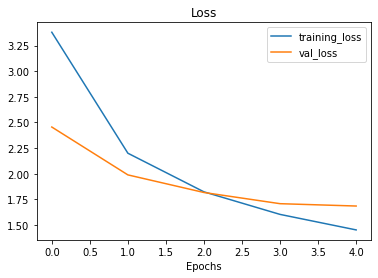

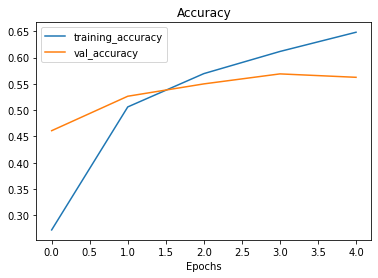

In [16]:
plot_loss_curves(history)

In [17]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

In [19]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [20]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [22]:
fine_tune_epochs = 10

history_1 = model.fit(train_data_all_10_percent,
                      epochs=fine_tune_epochs,
                      validation_data=test_data,
                      validation_steps=int(0.25*len(test_data)),
                      initial_epoch=history.epoch[-1])

Epoch 5/10


237/237 [==============================] - 106s 397ms/step - loss: 1.2205 - accuracy: 0.6854 - val_loss: 1.6524 - val_accuracy: 0.5658
Epoch 6/10
237/237 [==============================] - 91s 379ms/step - loss: 1.0973 - accuracy: 0.7104 - val_loss: 1.6620 - val_accuracy: 0.5628
Epoch 7/10
237/237 [==============================] - 80s 336ms/step - loss: 1.0048 - accuracy: 0.7295 - val_loss: 1.6671 - val_accuracy: 0.5617
Epoch 8/10
237/237 [==============================] - 79s 331ms/step - loss: 0.9501 - accuracy: 0.7457 - val_loss: 1.6615 - val_accuracy: 0.5684
Epoch 9/10
237/237 [==============================] - 76s 321ms/step - loss: 0.8827 - accuracy: 0.7612 - val_loss: 1.6380 - val_accuracy: 0.5707
Epoch 10/10
237/237 [==============================] - 77s 324ms/step - loss: 0.8311 - accuracy: 0.7762 - val_loss: 1.6590 - val_accuracy: 0.5698


In [23]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 58s 74ms/step - loss: 1.5033 - accuracy: 0.6038


[1.5032696723937988, 0.6037623882293701]

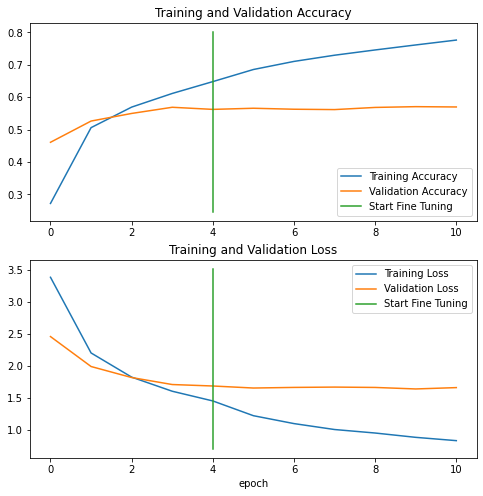

In [24]:
compare_historys(original_history=history,
                 new_history=history_1,
                 initial_epochs=5)

In [26]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)


--2023-03-09 12:34:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  60.0MB/s    in 0.7s    

2023-03-09 12:34:16 (60.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
model = tf.keras.models.load_model(saved_model_path.split(".")[0])

In [28]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 64s 79ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027204275131226, 0.6077623963356018)

In [29]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 73s 90ms/step


In [30]:
len(pred_probs)

25250

In [31]:
pred_probs.shape

(25250, 101)

In [33]:
pred_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [34]:
pred_classes = pred_probs.argmax(axis=1)

In [35]:
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [36]:
len(pred_classes)

25250

In [37]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
len(y_labels)

25250

In [40]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [41]:
from helper_functions import make_confusion_matrix

In [42]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

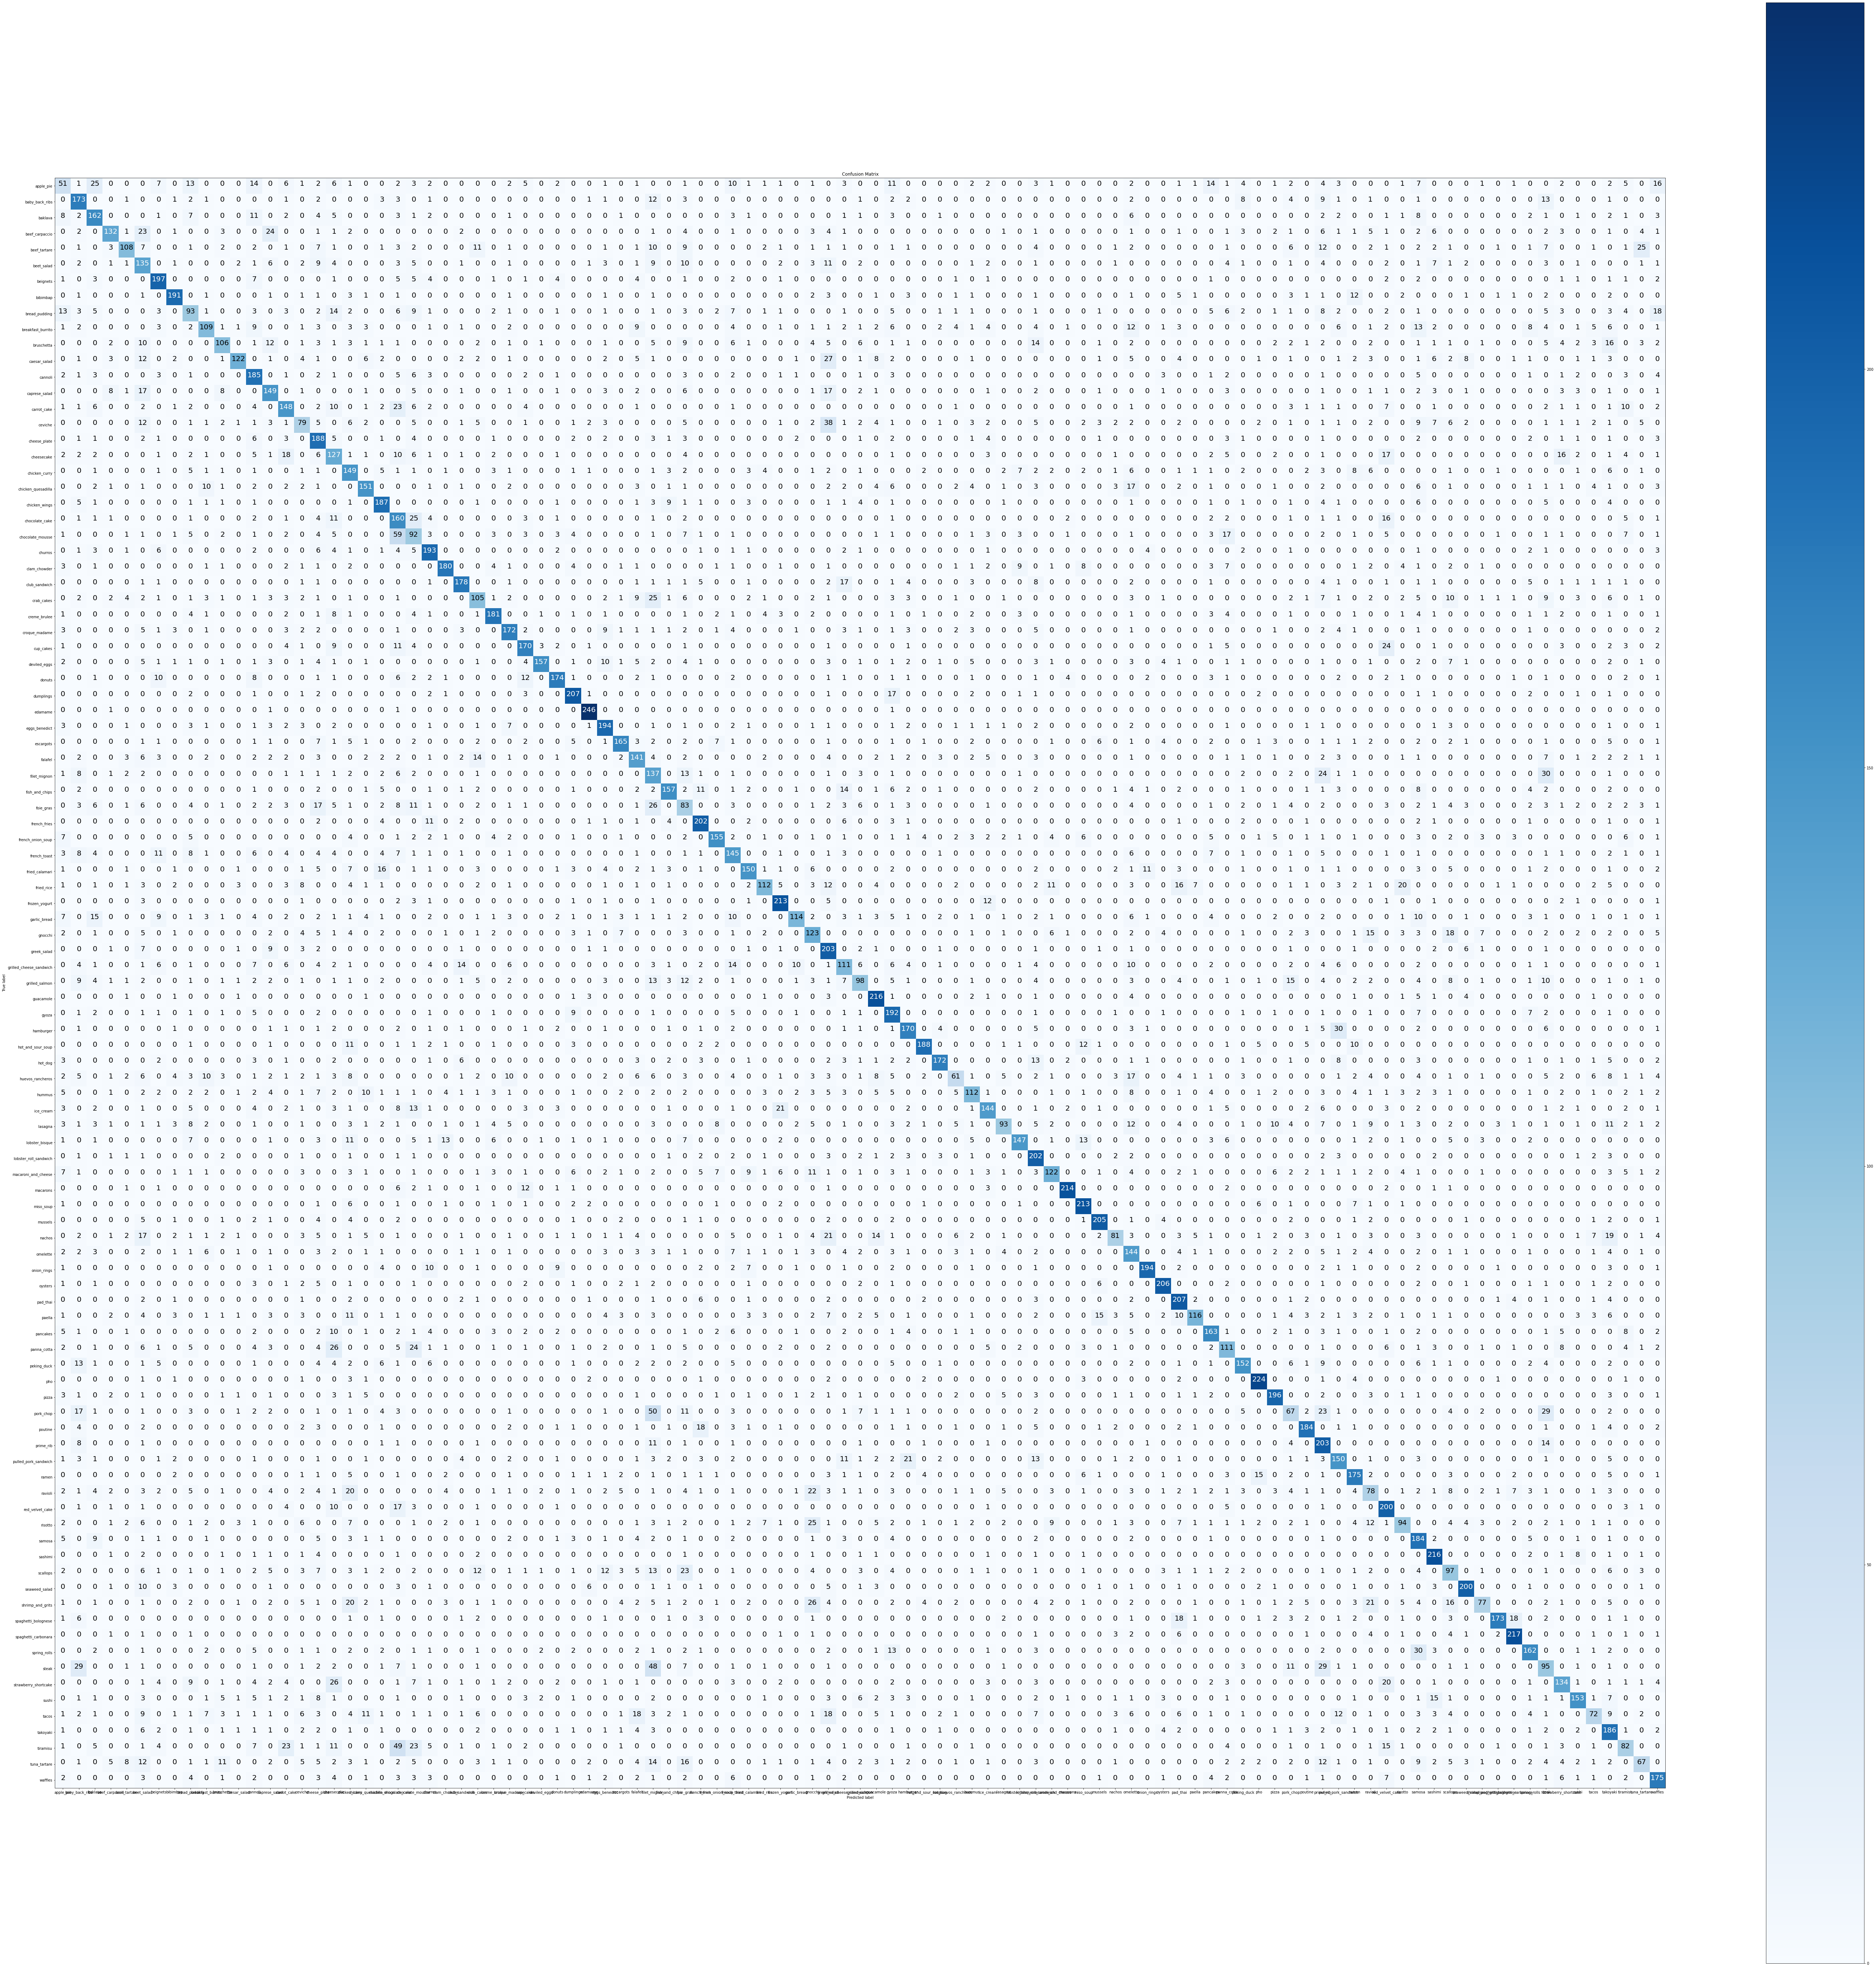

In [43]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [45]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [49]:
class_f1_scores = {}

for k,v in classification_report_dict.items():
  if k=="accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [50]:
f1_scores = pd.DataFrame({"class_name" : list(class_f1_scores.keys()),
                          "f1-score" : list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [51]:
f1_scores

,class_name,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


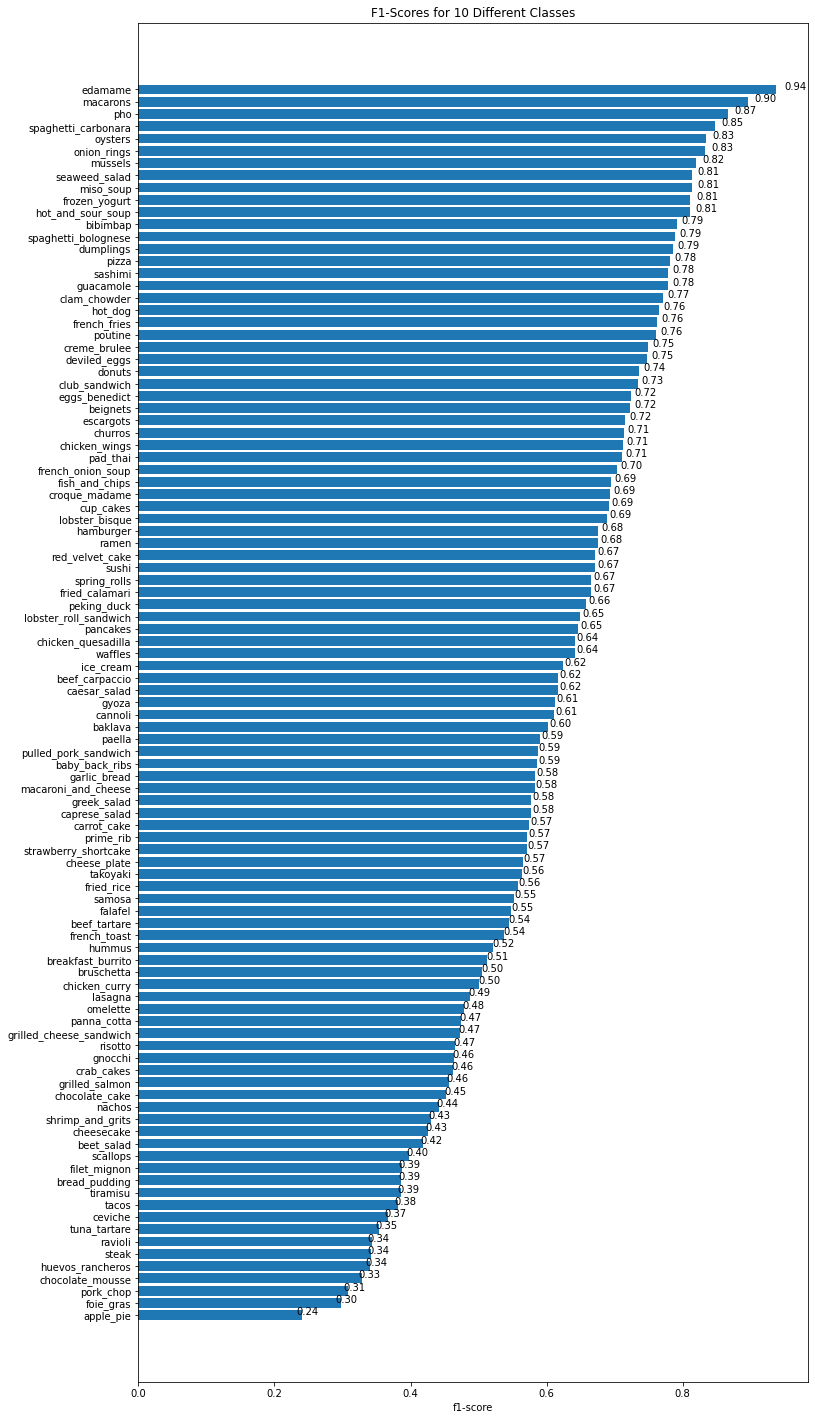

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [53]:

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img
     

1/1 [==============================] - 0s 47ms/step


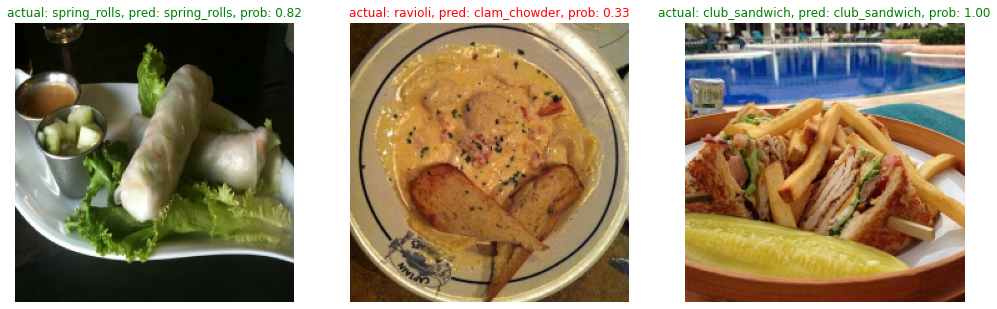

In [61]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [62]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [63]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847418,apple_pie,gyoza
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367901,apple_pie,prime_rib


In [64]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,52,0.847418,apple_pie,gyoza,False
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.964017,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.959259,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,79,0.367901,apple_pie,prime_rib,False


In [65]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'101_food_classes_10_percent/test/scallops/17...,87,29,0.999997,scallops,cup_cakes,False
231,b'101_food_classes_10_percent/test/apple_pie/8...,0,100,0.999995,apple_pie,waffles,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'101_food_classes_10_percent/test/samosa/3140...,85,92,0.999981,samosa,spring_rolls,False
24540,b'101_food_classes_10_percent/test/tiramisu/16...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'101_food_classes_10_percent/test/bruschetta/...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'101_food_classes_10_percent/test/chocolate_m...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.999931,paella,mussels,False
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.999904,sushi,sashimi,False


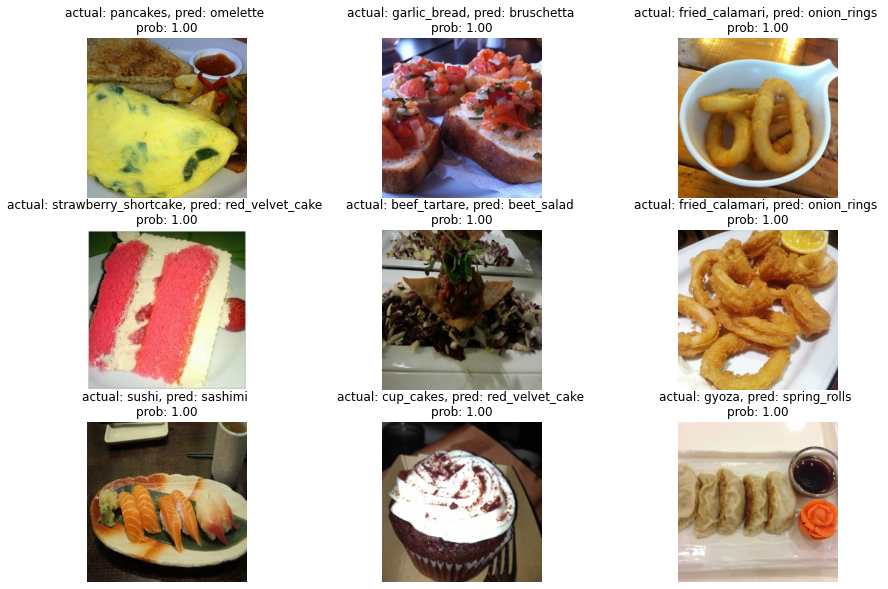

In [66]:
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [67]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 
     

--2023-03-09 14:29:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  74.5MB/s    in 0.2s    

2023-03-09 14:29:44 (74.5 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [68]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 71ms/step


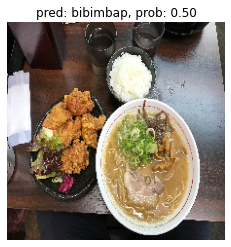

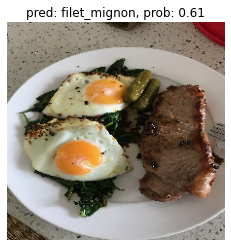

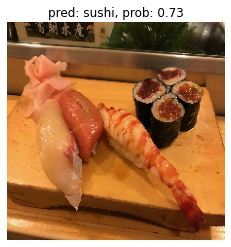

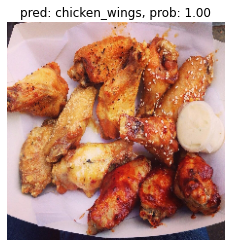

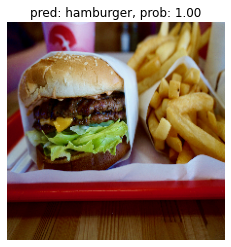

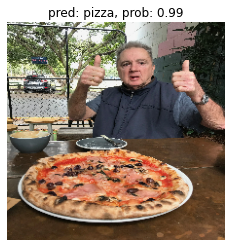

In [69]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)